In [25]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

class GraphState(TypedDict):
  messages: Annotated[list, add_messages]
  
def node_a(state: GraphState):
    print("================== Node_A Debug ==================")
    for message in state["messages"]:
      print(message)
    print("==================================================")
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    return GraphState(messages=[llm.invoke(state["messages"])])

def node_b(state: GraphState):
    print("================== Node_B Debug ==================")
    for message in state["messages"]:
      print(message)
    print("==================================================")
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    return GraphState(messages=[llm.invoke(state["messages"])])

graph_builder = StateGraph(GraphState)
graph_builder.add_node("node_a", node_a)
graph_builder.add_node("node_b", node_b)

graph_builder.add_edge(START, "node_a")
graph_builder.add_edge("node_a", "node_b")
graph_builder.add_edge("node_b", END)

graph = graph_builder.compile()

## 그래프 시각화

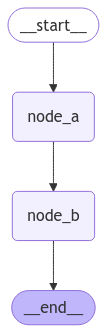

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

## 질의

In [27]:
def stream_graph_updates(query: str):
    input = GraphState(HumanMessage(content=query))
    events = graph.stream(input=input)
    for event in events:
        for value in event.values():
            print(f"AI 답변: {value["messages"]}")

In [28]:
stream_graph_updates(query="대한민국의 수도는?")

================== Node_A Debug ==================
content='대한민국의 수도는?' additional_kwargs={} response_metadata={} id='877bd7c2-d775-4c2f-825f-359da23d572e'
AI 답변: [AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 13, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-29c5d6fa-5f3d-42a0-8d0b-8d6bc91a58cb-0', usage_metadata={'input_tokens': 13, 'output_tokens': 9, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
================== Node_B Debug ==================
content='대한민국의 수도는?' additional_kwargs={} resp

결론적으로 `add_messages` 리듀서를 사용했을 때 메시지가 누적된다는 말은, 노드 간에 상태를 공유할 때 누적된다는 의미였다. 

이를 통해 정상적으로 메시지가 누적되는 것을 확인했고, 궁금했던 부분이 해소됐다.